#Data load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping




In [ ]:

# Install required packages (for Google Colab)
!pip install -q tensorflow matplotlib seaborn scikit-learn

In [ ]:
import tensorflow as tf

# Define directory paths for the dataset
base_dir = '/content/drive/My Drive/2025Paper Image classification/Large_Data224x224'
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

# Set image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load datasets using TensorFlow's image_dataset_from_directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)



Found 8757 files belonging to 3 classes.
Found 1094 files belonging to 3 classes.
Found 1097 files belonging to 3 classes.


In [ ]:
# Display GPU information (if available)
!nvidia-smi


Sun Jul  6 10:16:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             31W /   70W |     166MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Base Model MobileNetv3_small

In [ ]:
from itertools import filterfalse
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Multiply, Lambda, Reshape, BatchNormalization, Dropout
from tensorflow.keras import Model


# Build the model using MobileNetV3Small
base_model = MobileNetV3Small(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Set base model to trainable for fine-tuning
base_model.trainable = False

# Create the model architecture
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(train_dataset.class_names), activation='softmax')(x)
model = models.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 940,851 (3.59 MB)

 Trainable params: 1,731 (6.76 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Train the model with early stopping
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=150,
    callbacks=[early_stopping]
)

Epoch 1/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 52s 152ms/step - accuracy: 0.5930 - loss: 0.8860 - val_accuracy: 0.8729 - val_loss: 0.3737
Epoch 2/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 68s 116ms/step - accuracy: 0.8608 - loss: 0.3828 - val_accuracy: 0.8912 - val_loss: 0.2874
Epoch 3/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step - accuracy: 0.8858 - loss: 0.3180 - val_accuracy: 0.9141 - val_loss: 0.2533
Epoch 4/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 43s 115ms/step - accuracy: 0.8874 - loss: 0.2989 - val_accuracy: 0.9095 - val_loss: 0.2422
Epoch 5/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.8989 - loss: 0.2770 - val_accuracy: 0.9296 - val_loss: 0.2148
Epoch 6/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.9101 - loss: 0.2577 - val_accuracy: 0.9287 - val_loss: 0.2084
Epoch 7/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.9099 - loss: 0.2466 - val_accuracy: 0.9342 - val_loss: 0.2006
Epoch 8/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 39s 105ms/step - accuracy: 0.9075 -

In [ ]:
# Save the trained model
model.save('mobilenetv3_finetuned.keras')

# Evaluate the model on the test dataset
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Extract true labels from the test dataset
true_classes = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)

# Define class names (adjust based on your dataset)
class_names = ["Healthy", "Mites", "Virus"]  # Update with actual class labels

# Generate and print classification report
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_names
)
print("\nClassification Report:")
print(report)


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      0.94      0.94       309
       Mites       0.94      0.94      0.94       387
       Virus       0.96      0.96      0.96       401

    accuracy                           0.95      1097
   macro avg       0.95      0.95      0.95      1097
weighted avg       0.95      0.95      0.95      1097



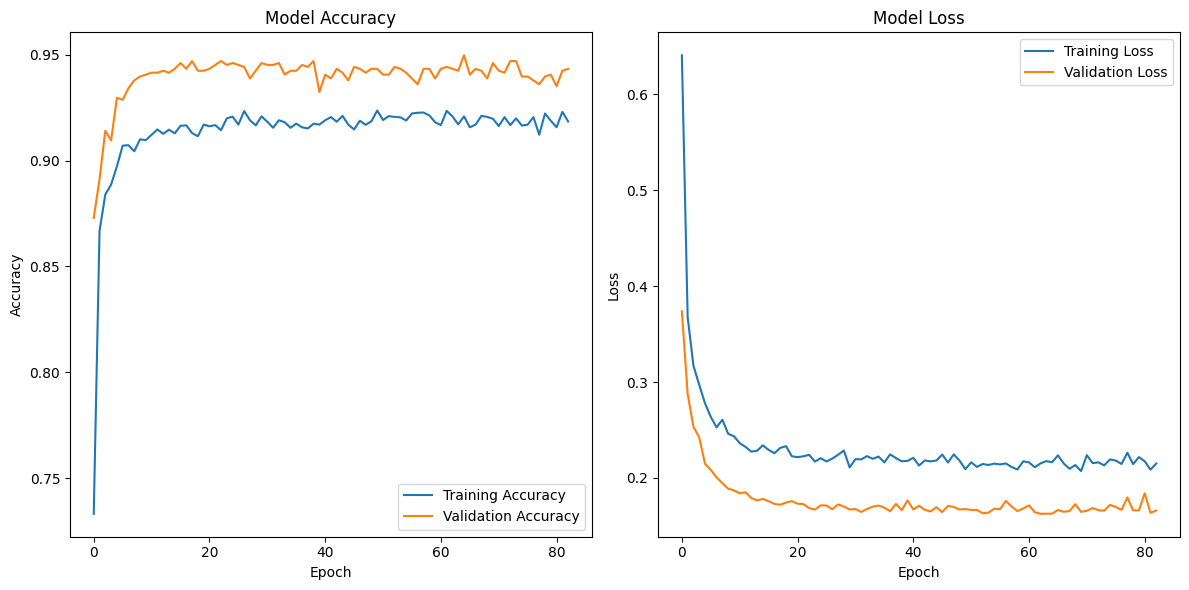

In [ ]:

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#SCA-Mobiplant with early stop

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Input, Conv2D, Multiply, Dropout,
    BatchNormalization, Concatenate, Lambda, Reshape, UpSampling2D
)

# Custom h_swish activation function
def h_swish(x):
    return x * tf.nn.relu6(x + 3.0) / 6.0

# Custom Squeeze-and-Excitation Coordinate Attention (SCA) Layer
class SCA(layers.Layer):
    def __init__(self, groups=32, reduction_ratio=16, **kwargs):
        super(SCA, self).__init__(**kwargs)
        self.groups = groups
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        _, self.height, self.width, self.channels = input_shape
        self.mip = max(8, self.channels // self.groups)

        # Conv2D layers for processing
        self.conv = Conv2D(self.mip, kernel_size=1, strides=1, padding='same', use_bias=False)
        self.bn = BatchNormalization()

        # Parallel FC paths for channel weight generation
        self.fc1 = Dense(self.channels // self.reduction_ratio, activation='relu')
        self.fc2 = Dense(self.channels // self.reduction_ratio, activation='relu')
        self.fc_final = Dense(self.channels, activation='sigmoid')

        # Conv2D layers for height and width attention
        self.conv_h = Conv2D(self.channels, kernel_size=1, strides=1, padding='same', activation='sigmoid')
        self.conv_w = Conv2D(self.channels, kernel_size=1, strides=1, padding='same', activation='sigmoid')

    def call(self, x):
        # H-wise pooling
        x_h = tf.reduce_mean(x, axis=2, keepdims=True)  # Shape: [batch, height, 1, channels]
        # W-wise pooling
        x_w = tf.reduce_mean(x, axis=1, keepdims=True)  # Shape: [batch, 1, width, channels]
        x_w = tf.transpose(x_w, [0, 2, 1, 3])  # Shape: [batch, width, 1, channels]

        # Concatenate and process
        y = tf.concat([x_h, x_w], axis=1)  # Shape: [batch, height + width, 1, channels]
        y = self.conv(y)  # Shape: [batch, height + width, 1, mip]
        y = self.bn(y)
        y = Lambda(h_swish)(y)  # Use Lambda layer for h_swish

        # Split and apply sigmoid
        x_h, x_w = tf.split(y, [self.height, self.width], axis=1)  # Shapes: [batch, height, 1, mip], [batch, width, 1, mip]
        x_w = tf.transpose(x_w, [0, 2, 1, 3])  # Shape: [batch, 1, width, mip]

        # Generate height and width attention maps
        x_h = self.conv_h(x_h)  # Shape: [batch, height, 1, channels]
        x_w = self.conv_w(x_w)  # Shape: [batch, 1, width, channels]

        # Expand and apply attention
        x_h = tf.tile(x_h, [1, 1, self.width, 1])  # Shape: [batch, height, width, channels]
        x_w = tf.tile(x_w, [1, self.height, 1, 1])  # Shape: [batch, height, width, channels]

        # Combine height and width attention
        spatial_attention = x * x_w * x_h  # Shape: [batch, height, width, channels]

        # Global Average Pooling for channel attention
        gap = tf.reduce_mean(spatial_attention, axis=[1, 2], keepdims=True)  # Shape: [batch, 1, 1, channels]

        # Parallel FC paths for channel weight generation
        fc1_out = self.fc1(gap)  # Shape: [batch, 1, 1, channels // reduction_ratio]
        fc2_out = self.fc2(gap)  # Shape: [batch, 1, 1, channels // reduction_ratio]

        # Concatenate FC outputs
        fc_concat = Concatenate(axis=-1)([fc1_out, fc2_out])  # Shape: [batch, 1, 1, 2 * (channels // reduction_ratio)]

        # Final FC layer for channel weights
        channel_weights = self.fc_final(fc_concat)  # Shape: [batch, 1, 1, channels]

        # Apply channel attention
        output = spatial_attention * channel_weights  # Shape: [batch, height, width, channels]

        return output

    def get_config(self):
        config = super(SCA, self).get_config()
        config.update({'groups': self.groups, 'reduction_ratio': self.reduction_ratio})
        return config
# Load MobileNetV3Small with pre-trained ImageNet weights
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = True

# Extract feature maps from early, middle, late, and additional stages
# Early stage: After the first bottleneck block
stage1_output = base_model.get_layer('expanded_conv_project_bn').output  # Shape: (None, 56, 56, 16)
# Middle stage: After the third bottleneck block
stage2_output = base_model.get_layer('expanded_conv_3_project_bn').output  # Shape: (None, 28, 28, 40)
# Late stage: After the sixth bottleneck block
stage3_output = base_model.get_layer('expanded_conv_6_project_bn').output  # Shape: (None, 14, 14, 48)
# Additional stage: After the last bottleneck block
stage4_output = base_model.get_layer('expanded_conv_9_project_bn').output  # Shape: (None, 7, 7, 96)

# Apply SCA to early, middle, late, and additional stages
sca_stage1 = SCA()(stage1_output)  # Early stage SCA
sca_stage2 = SCA()(stage2_output)  # Middle stage SCA
sca_stage3 = SCA()(stage3_output)  # Late stage SCA
sca_stage4 = SCA()(stage4_output)  # Additional stage SCA

# Resize early and middle-stage feature maps to match late-stage spatial dimensions (14x14)
sca_stage1_resized = Conv2D(filters=48, kernel_size=1, strides=4, padding='same')(sca_stage1)  # Downsample to 14x14
sca_stage2_resized = Conv2D(filters=48, kernel_size=1, strides=2, padding='same')(sca_stage2)  # Downsample to 14x14

sca_stage2_resized = UpSampling2D(size=(2, 2))(sca_stage2_resized)  # Upsample to 14x14

# Resize the additional stage feature map to match the spatial dimensions (14x14)
sca_stage4_resized = UpSampling2D(size=(2, 2))(sca_stage4)  # Upsample to 14x14

# Combine feature maps using concatenation
combined_features = Concatenate(axis=-1)([
    sca_stage1_resized,  # 14x14x48
    sca_stage2_resized,  # 14x14x48
    sca_stage3,          # 14x14x48
    sca_stage4_resized   # 14x14x96
])  # Shape: (None, 14, 14, 240)

# Global Average Pooling and classification head
x = GlobalAveragePooling2D()(combined_features)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)  # Increased neurons
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout rate
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)  # Additional dense layer
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(3, activation='softmax')(x)  # 3 classes

# Create the final model
model21 = models.Model(inputs=base_model.input, outputs=outputs)

# Set a custom learning rate with a scheduler
initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model
model21.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model21.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 693,043 (2.64 MB)

 Trainable params: 683,747 (2.61 MB)

 Non-trainable params: 9,296 (36.31 KB)

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Train the model with early stopping
history = model21.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=150,
    callbacks=[early_stopping]
)

Epoch 1/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 146s 292ms/step - accuracy: 0.7331 - loss: 2.7294 - val_accuracy: 0.7486 - val_loss: 2.3252
Epoch 2/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 67s 129ms/step - accuracy: 0.9343 - loss: 1.7414 - val_accuracy: 0.8976 - val_loss: 1.4942
Epoch 3/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - accuracy: 0.9690 - loss: 1.2284 - val_accuracy: 0.9479 - val_loss: 0.9993
Epoch 4/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 67s 123ms/step - accuracy: 0.9692 - loss: 0.8795 - val_accuracy: 0.9543 - val_loss: 0.7262
Epoch 5/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.9843 - loss: 0.5985 - val_accuracy: 0.9598 - val_loss: 0.5794
Epoch 6/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 42s 128ms/step - accuracy: 0.9818 - loss: 0.4343 - val_accuracy: 0.9735 - val_loss: 0.3815
Epoch 7/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 35s 127ms/step - accuracy: 0.9837 - loss: 0.3116 - val_accuracy: 0.8976 - val_loss: 0.5742
Epoch 8/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.9866 

In [ ]:
# Save the trained model
model21.save('SCA_Mobiplant.keras')

# Evaluate the model on the test dataset
predictions = model21.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Extract true labels from the test dataset
true_classes = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)

# Define class names (adjust based on your dataset)
class_names = ["Healthy", "Mites", "Virus"]  # Update with actual class labels

# Generate and print classification report
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_names
)
print("\nClassification Report:")
print(report)


35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       309
       Mites       1.00      1.00      1.00       387
       Virus       1.00      1.00      1.00       401

    accuracy                           1.00      1097
   macro avg       1.00      1.00      1.00      1097
weighted avg       1.00      1.00      1.00      1097



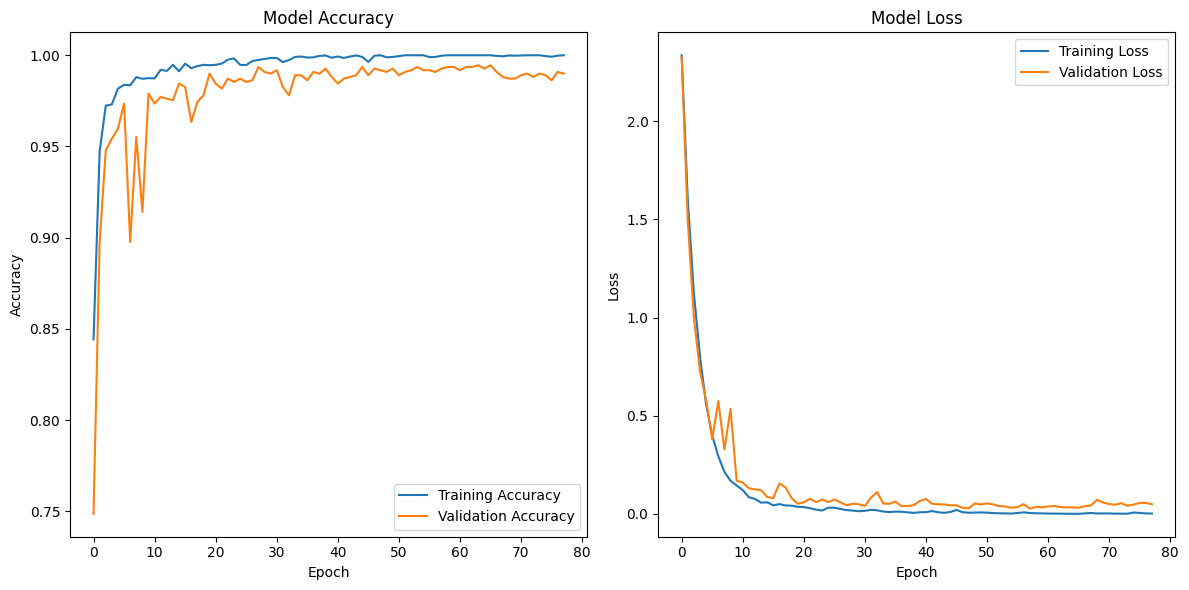

In [ ]:

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#Convert the Model to TFLite Format

In [ ]:
import tensorflow as tf

# Load the saved Keras model
model = tf.keras.models.load_model('SCA_Mobiplant.keras', custom_objects={'SCA': SCA})

# Convert to TFLite (float32)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('SCA_Mobiplant.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpb6bctc1s'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_20')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137760445828752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137760471041232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137760471040080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137760471041424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137760471040272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137760471042768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137760471043152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137760471043536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137760471043344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137760471041616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137760471044

2. Verify TFLite Model for Mobile Deployment

Step 1: Check Model Compatibility

In [ ]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='SCA_Mobiplant.tflite')
interpreter.allocate_tensors()

# Get input/output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])  # Expected: [1, 224, 224, 3]
print("Output Shape:", output_details[0]['shape'])  # Expected: [1, 3]

Input Shape: [  1 224 224   3]
Output Shape: [1 3]


Step 2: Test Inference

In [ ]:
import numpy as np

# Mock input (replace with actual image data)
input_data = np.random.rand(1, 224, 224, 3).astype(np.float32)

# Run inference
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

print("Prediction:", output_data)  # Should output class probabilities

Prediction: [[0.8773229  0.0013072  0.12136989]]


Step 3: Benchmark Latency

In [ ]:
import time

# Warmup
interpreter.invoke()

# Measure inference time
start = time.time()
for _ in range(100):
    interpreter.invoke()
print(f"Avg latency: {(time.time() - start) / 100 * 1000:.2f} ms")

Avg latency: 2.10 ms


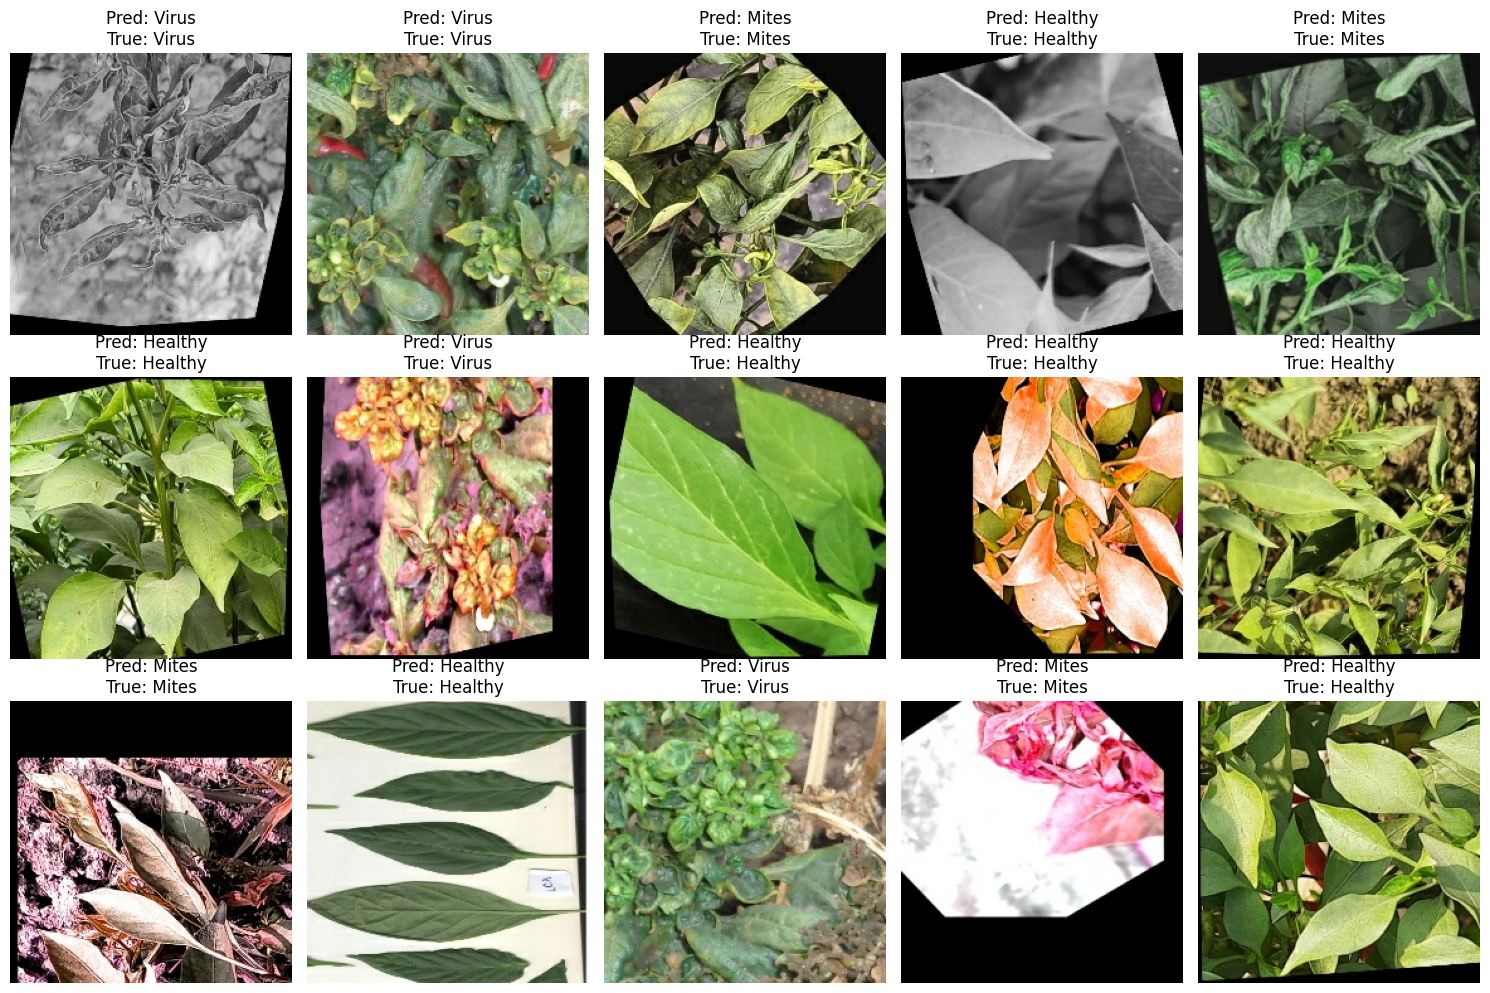

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="SCA_Mobiplant.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Assume image size and class names
IMG_SIZE = (224, 224)
class_names = ['Healthy', 'Mites', 'Virus']

# Unbatch test dataset into image-label pairs
test_images = []
test_labels = []

for img, label in test_dataset.unbatch().take(1000):  # Adjust as needed
    test_images.append(img.numpy())
    test_labels.append(label.numpy())

# Select 15 random images from test set
random_indices = random.sample(range(len(test_images)), 15)

# Plot and predict
plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    image = test_images[idx]
    label = test_labels[idx]

    # Preprocess: expand dims & convert to float32
    input_image = np.expand_dims(image, axis=0).astype(np.float32)

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_image)

    # Run inference
    interpreter.invoke()

    # Get output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data)

    # Plot image
    plt.subplot(3, 5, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(f"Pred: {class_names[predicted_class]}\nTrue: {class_names[label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
